<h1 id="tocheading">Оглавление</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Описание проекта

Вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Шаги для выбора локации обычно такие:
* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.


**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные. Поясните порядок действий.


2. Обучите и проверьте модель для каждого региона:

2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.

2.2. Обучите модель и сделайте предсказания на валидационной выборке.

2.3. Сохраните предсказания и правильные ответы на валидационной выборке.

2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.

2.5. Проанализируйте результаты.


3. Подготовьтесь к расчёту прибыли:

3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.

3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.

3.3. Напишите выводы по этапу подготовки расчёта прибыли.


4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

4.1. Выберите скважины с максимальными значениями предсказаний.

4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.

4.3. Рассчитайте прибыль для полученного объёма сырья.


5. Посчитайте риски и прибыль для каждого региона:

5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.


**Описание данных**

Данные геологоразведки трёх регионов находятся в 3 файлах.

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).


**Условия задачи:**

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. 

Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. 

Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# Изучение данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [3]:
geo_data_0 = pd.read_csv('/filename_0.csv')
geo_data_1 = pd.read_csv('/filename_1.csv')
geo_data_2 = pd.read_csv('/filename_2.csv')

datasets = [geo_data_0, geo_data_1, geo_data_2]

In [4]:
display(geo_data_0.head())
display(geo_data_1.head())
display(geo_data_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [5]:
display(geo_data_0.info())
display(geo_data_1.info())
display(geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [6]:
display(geo_data_0.describe())
display(geo_data_1.describe())
display(geo_data_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [7]:
#Посмотрим на уникальные значения в каждом столбце
columns = list(geo_data_0)

for i in columns:
    display('geo_data_0 {} {}'.format(i, geo_data_0[i].sort_values().unique()))
    

columns = list(geo_data_1)

for i in columns:
    display('geo_data_1 {} {}'.format(i, geo_data_0[i].sort_values().unique()))
    
columns = list(geo_data_2)

for i in columns:
    display('geo_data_2 {} {}'.format(i, geo_data_0[i].sort_values().unique()))

"geo_data_0 id ['006OJ' '009eY' '00AfQ' ... 'zztWK' 'zzyhQ' 'zzzLH']"

'geo_data_0 f0 [-1.40860531 -1.35177299 -1.30222711 ...  2.33375269  2.33707957\n  2.36233081]'

'geo_data_0 f1 [-0.8482185  -0.84490792 -0.8205609  ...  1.33334561  1.33482762\n  1.34376933]'

'geo_data_0 f2 [-12.08832812 -10.13834135 -10.13817115 ...  15.23032159  15.42837187\n  16.00379001]'

'geo_data_0 product [0.00000000e+00 4.02152316e-03 6.11363631e-03 ... 1.85355615e+02\n 1.85362690e+02 1.85364347e+02]'

"geo_data_1 id ['006OJ' '009eY' '00AfQ' ... 'zztWK' 'zzyhQ' 'zzzLH']"

'geo_data_1 f0 [-1.40860531 -1.35177299 -1.30222711 ...  2.33375269  2.33707957\n  2.36233081]'

'geo_data_1 f1 [-0.8482185  -0.84490792 -0.8205609  ...  1.33334561  1.33482762\n  1.34376933]'

'geo_data_1 f2 [-12.08832812 -10.13834135 -10.13817115 ...  15.23032159  15.42837187\n  16.00379001]'

'geo_data_1 product [0.00000000e+00 4.02152316e-03 6.11363631e-03 ... 1.85355615e+02\n 1.85362690e+02 1.85364347e+02]'

"geo_data_2 id ['006OJ' '009eY' '00AfQ' ... 'zztWK' 'zzyhQ' 'zzzLH']"

'geo_data_2 f0 [-1.40860531 -1.35177299 -1.30222711 ...  2.33375269  2.33707957\n  2.36233081]'

'geo_data_2 f1 [-0.8482185  -0.84490792 -0.8205609  ...  1.33334561  1.33482762\n  1.34376933]'

'geo_data_2 f2 [-12.08832812 -10.13834135 -10.13817115 ...  15.23032159  15.42837187\n  16.00379001]'

'geo_data_2 product [0.00000000e+00 4.02152316e-03 6.11363631e-03 ... 1.85355615e+02\n 1.85362690e+02 1.85364347e+02]'

Решено удалить столбец 'id' из всех датасетов, т.к. для модели он бесполезен.

In [8]:
geo_data_0 = geo_data_0.drop('id', 1)
geo_data_1 = geo_data_1.drop('id', 1)
geo_data_2 = geo_data_2.drop('id', 1)

In [9]:
#проверка
display(geo_data_0.columns)
display(geo_data_1.columns)
display(geo_data_2.columns)

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

In [10]:
#посмотрим на корреляцию значений признаков в датасетах
for data in datasets:
    display(data.corr(), '\n')

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


'\n'

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


'\n'

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


'\n'

Во втором датасете (geo_data_1) установлена линейная зависимость между параметром объема запасов скважины и признаком f2.

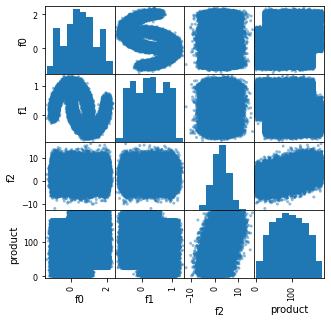

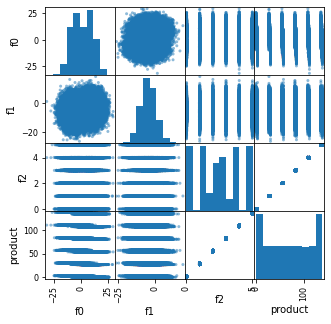

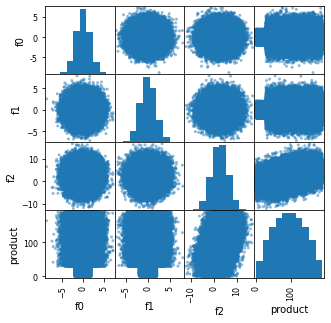

In [11]:
for data in datasets:
    pd.plotting.scatter_matrix(data, figsize=(5, 5)) 

### Вывод

Загрузили и проверили данные. Критических ошибок при первичном изучении не выявлено. пропущенных значений, прописных букв в названии столбцов нет.

Удалили столбец id, т.к. для обучения модели он не представляет значимости.

Обнаружили сильную корреляцию между признаком f2 и параметром объема запасов скважины в датасете geo_data_1.

## Обучение и проверка модели для каждого региона

Обучите и проверьте модель для каждого региона:

2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.

2.2. Обучите модель и сделайте предсказания на валидационной выборке.

2.3. Сохраните предсказания и правильные ответы на валидационной выборке.

2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.

2.5. Проанализируйте результаты.

Разобьем датасеты на обучающую и валидационную выборки и проведем масштабирование признаков

In [12]:
state = np.random.RandomState(12345)

def splitting(region_number): # функция разбивает на тренировочные и валидационные выборки и отделяет целевой признак
    train, valid = train_test_split(region_number, test_size=0.25, random_state=state)
    features_train = train.drop(columns=['product'], axis=0)
    target_train = train['product']
    features_valid = valid.drop(columns=['product'], axis=0)
    target_valid= valid['product']
    return features_train, target_train, features_valid, target_valid

In [13]:
#разделили на обучающую и валидационную выборки
features_train_0, target_train_0, features_valid_0, target_valid_0 = splitting(geo_data_0)
features_train_1, target_train_1, features_valid_1, target_valid_1 = splitting(geo_data_1)
features_train_2, target_train_2, features_valid_2, target_valid_2 = splitting(geo_data_2)

In [14]:
#масштабируем признаки
scaler = StandardScaler()
scaler.fit(features_train_0)
features_train_0 = scaler.transform(features_train_0)
features_valid_0 = scaler.transform(features_valid_0)

scaler.fit(features_train_1)
features_train_1 = scaler.transform(features_train_1)
features_valid_1 = scaler.transform(features_valid_1)

scaler.fit(features_train_2)
features_train_2 = scaler.transform(features_train_2)
features_valid_2 = scaler.transform(features_valid_2)


Обучим модель на тренировочной выборке

In [15]:
model = LinearRegression()
def learning_and_predicted(features_train, target_train, features_valid, target_valid):# Функция для обучения и прогнозирования
    model.fit(features_train, target_train)
    predict = pd.Series(model.predict(features_valid), target_valid.index)
    return predict

In [16]:
#предскажем целевой признак по валидационным выборкам
predict_0 = learning_and_predicted(features_train_0, target_train_0, features_valid_0, target_valid_0)
predict_1 = learning_and_predicted(features_train_1, target_train_1, features_valid_1, target_valid_1)
predict_2 = learning_and_predicted(features_train_2, target_train_2, features_valid_2, target_valid_2)


In [17]:
predictions = [predict_0, predict_1, predict_2]
targets_valid = [target_valid_0, target_valid_1, target_valid_2]
for i in range(len(predictions)):
    print('Регион', i)
    mse = mean_squared_error(predictions[i], targets_valid[i])
    print('Предсказанный средний запас: {:,.2f}'.format(predictions[i].mean()))
    print('RMSE: {:,.2f}'.format(mse ** 0.5), '\n')

Регион 0
Предсказанный средний запас: 92.59
RMSE: 37.58 

Регион 1
Предсказанный средний запас: 68.77
RMSE: 0.89 

Регион 2
Предсказанный средний запас: 95.09
RMSE: 39.96 



В нулевом и втором регионе модель достаточно сильно ошибается, зато в регионе 1 (регионе с индексом 1), благодаря сильной зависимости целевого признака от одного из признаков, мы имеем достаточно точные предсказания.

## Подготовка к расчету прибыли

3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.

3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.

3.3. Напишите выводы по этапу подготовки расчёта прибыли.

In [18]:
TOTAL_BUDGET = 10e9 # бюджет всего в экспоненциальном формате
TOTAL_WELLS = 200 # скважин всего
COST_THOUSAND_BARREL = 450e3 # цена за 1000 баррелей в экспоненциальном формате
RISK = 0.025 # допустимый риск
well_cost = (TOTAL_BUDGET / TOTAL_WELLS) # цена за скважину
min_bulk = well_cost/ COST_THOUSAND_BARREL # минимальный объем для окупаемости скважины

print('Цена одной скважины: {:.2f} млн руб.'.format(well_cost/1000000))
print('Минимальный объем в скважине, для окупаемости: {:.2f} тыс.барр.'.format(min_bulk))

Цена одной скважины: 50.00 млн руб.
Минимальный объем в скважине, для окупаемости: 111.11 тыс.барр.


### Выводы

Была подготовлена средняя оценка прибыли за скважину и средний объем на скважину. И создана функция по расчету прибыли.

Минимальный объем для окупаемости скважины - 111.11 тыс.бар. 

Из трех регионов средний объем сырья сопоставим с данным значением в регионе 0 и в регионе 2.

Однако максимальные показатели объема запасов из таблиц с описательной статистикой позволяют сделать вывод о наличии в каждом регионе потенциально богатых скважин, способных окупить проект.

Инвестиции в 1 скважину == 50 млн руб.


## Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

1. Выберите скважины с максимальными значениями предсказаний.

2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.

3. Рассчитайте прибыль для полученного объёма сырья.

In [19]:
def get_profit(target, predictions):
    preds_sorted = predictions.sort_values(ascending=False)
    selected = target[preds_sorted.index][:TOTAL_WELLS]
    #print(selected.shape) #проверка
    return selected.sum() * COST_THOUSAND_BARREL - TOTAL_BUDGET

print ('Расчетная прибыль для топ-200 скважин региона 0: {:.0f} млн руб.'.format(get_profit(target_valid_0, predict_0)/1000000))
print ('Расчетная прибыль для топ-200 скважин региона 1: {:.0f} млн руб.'.format(get_profit(target_valid_1, predict_1)/1000000))
print ('Расчетная прибыль для топ-200 скважин региона 2: {:.0f} млн руб.'.format(get_profit(target_valid_2, predict_2)/1000000))

Расчетная прибыль для топ-200 скважин региона 0: 3321 млн руб.
Расчетная прибыль для топ-200 скважин региона 1: 2415 млн руб.
Расчетная прибыль для топ-200 скважин региона 2: 2540 млн руб.


## Выводы

Мы написали функцию, позволяющую оценить расчетный объем добычи в каждом регионе и соответствующую ему прибыль. Функция работает на основе предсказаний созданной нами модели, считая прибыль по топ-200 из всех возможных скважин региона.

Согласно этим предсказаниям, максимальная расчетная прибыль - в регионе 0 == 3,4 млрд руб., минимальная - в регионе 1 == 2,4 млрд руб.

# Посчитайте риски и прибыль для каждого региона

1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [20]:
for i in range(len(targets_valid)):
    values = []
    for _ in range(1000):
        target_subsample = targets_valid[i].sample(n=500, replace=True, random_state=state)
        pred_subsample = predictions[i][target_subsample.index]
        prof=get_profit(target_subsample, pred_subsample)
        values.append(prof)
                
    name = 'регион №' + str(i)    
    values=pd.Series(values)
    lower=values.quantile(RISK)
    upper=values.quantile(0.975)
    mean=values.mean()
    loss=(values < 0).mean()
    print(name)
    print('Средняя прибыль:', mean/1000000, 'млн руб.')
    print ('95% доверительный интервал: от', lower/1000000, 'млн руб. до ', upper/1000000, 'млн руб.'.format(lower/1000000, ))
    print('Риск убытков:', loss )
    print('\n')
    

регион №0
Средняя прибыль: 423.89723791690534 млн руб.
95% доверительный интервал: от -76.18781389036272 млн руб. до  957.8465319517829 млн руб.
Риск убытков: 0.048


регион №1
Средняя прибыль: 513.2566989172609 млн руб.
95% доверительный интервал: от 108.06689523396211 млн руб. до  928.5744392324963 млн руб.
Риск убытков: 0.006


регион №2
Средняя прибыль: 381.12035957590143 млн руб.
95% доверительный интервал: от -142.80063008786877 млн руб. до  893.3805657504003 млн руб.
Риск убытков: 0.074




### Выводы

С помощью техники BOOTSTRAP мы оценили среднюю прибыль от проекта в каждом регионе, на основе 200 лучших скважин из 500 случайно выбранных.

Получается, что минимальный риск получить убыток (0,6%) и максимальная средняя прибыль (513 млн руб.) характерны для региона  с индексом 1.

С вероятностью 95% прибыль от рееализации проекта будет не ниже 108 млн руб.

# Общий вывод

Условиям заказчика отвечает регион под индексом 1.
* риск убытков 0.6%.
* с вероятностью 95% прибыль от проекта будет не менее 108 млн руб.
* средняя предполагаемая прибыль составляет 513 млн руб.
* в этом районе есть очень хороший признак, позволяющий нам считать модель предсказания эффективной (RMSE = 0.89)